In [1]:
import torch
import torch.nn as nn
import math
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR
from torchvision import datasets, transforms

# Load Dataset

In [3]:
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, 4),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
])

trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = DataLoader(trainset, batch_size=256, shuffle=True, drop_last = True)

testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = DataLoader(testset, batch_size=256, shuffle=False, drop_last = True)

Files already downloaded and verified
Files already downloaded and verified


# Model

In [4]:
class VGG(nn.Module):
    def __init__(self):
        super(VGG, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
        )

        self.classifier = nn.Sequential(
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, 10),
            nn.Softmax(dim=1)
        )

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                m.bias.data.zero_()

    def forward(self, x):
        x = self.features(x)
        x = x.view(-1, 512)
        x = self.classifier(x)
        return x


# Train Function

In [5]:
def train(criterion, optimizer, scheduler, model, num_epochs, device):
    loss_history = []
    test_acc_history = []

    for epoch in range(num_epochs):
        model.train()
        loss_per_epoch = 0

        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            loss_per_epoch += loss.item()

        scheduler.step()

        correct = 0
        total = 0
        model.eval()

        with torch.no_grad():
            for images, labels in testloader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        epoch_loss = loss_per_epoch / len(trainloader)
        epoch_acc = correct / total

        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}, Test Accuracy: {epoch_acc:.4f}")
        loss_history.append(epoch_loss)
        test_acc_history.append(epoch_acc)

    return loss_history, test_acc_history

In [6]:
model = VGG()
model = model.to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), 0.05,
                                momentum=0.9, weight_decay=5e-4)

scheduler = StepLR(optimizer, step_size=10, gamma=0.5)

num_epochs = 100
loss_history, test_acc_history = train(criterion, optimizer, scheduler, model, num_epochs, DEVICE)

Epoch [1/100], Loss: 2.0976, Test Accuracy: 0.4593
Epoch [2/100], Loss: 1.9482, Test Accuracy: 0.4956
Epoch [3/100], Loss: 1.8808, Test Accuracy: 0.5353
Epoch [4/100], Loss: 1.8420, Test Accuracy: 0.6391
Epoch [5/100], Loss: 1.8094, Test Accuracy: 0.6631
Epoch [6/100], Loss: 1.7718, Test Accuracy: 0.6318
Epoch [7/100], Loss: 1.7466, Test Accuracy: 0.7089
Epoch [8/100], Loss: 1.7288, Test Accuracy: 0.7056
Epoch [9/100], Loss: 1.7124, Test Accuracy: 0.7203
Epoch [10/100], Loss: 1.7052, Test Accuracy: 0.7626
Epoch [11/100], Loss: 1.6710, Test Accuracy: 0.7745
Epoch [12/100], Loss: 1.6558, Test Accuracy: 0.7993
Epoch [13/100], Loss: 1.6491, Test Accuracy: 0.7932
Epoch [14/100], Loss: 1.6433, Test Accuracy: 0.7976
Epoch [15/100], Loss: 1.6407, Test Accuracy: 0.7852
Epoch [16/100], Loss: 1.6392, Test Accuracy: 0.7943
Epoch [17/100], Loss: 1.6339, Test Accuracy: 0.7873
Epoch [18/100], Loss: 1.6322, Test Accuracy: 0.8194
Epoch [19/100], Loss: 1.6264, Test Accuracy: 0.8097
Epoch [20/100], Loss:

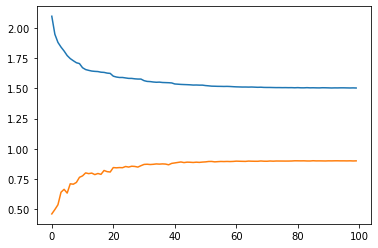

In [7]:
import matplotlib.pyplot as plt

plt.plot(list(range(num_epochs)), loss_history)
plt.plot(list(range(num_epochs)), test_acc_history)
plt.show()